In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import statsmodels.api as sm
from math import floor
from sklearn import linear_model
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as ts
from datetime import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
from matplotlib.dates import date2num

/Users/frederikfindsen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/frederikfindsen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [7]:
crsp_daily = pd.read_csv('/Users/frederikfindsen/Documents/Økonomi/8. Semester/Seminar/crsp_daily.csv',index_col='date',parse_dates=True)
factors_ff = pd.read_csv('/Users/frederikfindsen/Documents/Økonomi/8. Semester/Seminar/factors_daily.csv',index_col='date',parse_dates=True)
crsp_monthly = pd.read_csv("/Users/frederikfindsen/Documents/Økonomi/8. Semester/Seminar/crsp_monthly.csv",index_col='date',parse_dates=True)
industry = crsp_monthly[['permno','industry']].reset_index().drop_duplicates()

In [8]:
data = crsp_daily.reset_index().pivot(index='date',columns='permno',values='ret_excess').iloc[:,0:1000]

#Making returns to closing prices
start = 100
for column in data:
    data[column] = start*(1+data[column]).cumprod()

In [9]:
data

permno,10001,10002,10012,10025,10026,10028,10032,10042,10044,10051,...,14471,14472,14478,14479,14487,14489,14490,14495,14497,14498
date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,96.658666,96.822554,84.458022,100.466574,96.953049,107.793419,92.151874,93.742006,98.968112,99.745081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-04,94.332287,95.270851,83.286325,99.306086,96.353865,107.182005,85.995918,90.609767,103.737964,99.490214,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-05,97.077904,90.997366,76.678885,97.603498,95.469285,98.557741,83.990926,90.602518,102.364693,98.247880,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-06,94.317189,86.724588,84.437699,97.189012,95.991810,99.258904,81.602027,90.595270,103.994337,98.610298,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-07,94.831210,84.889728,80.548749,96.910138,95.127785,102.086938,83.516451,88.245043,106.988483,96.134068,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24,328.865080,NaN,NaN,337.434517,430.026495,42.705689,281.606157,NaN,163.658292,248.799716,...,102.756194,72.840905,115.865707,144.296867,73.418531,117.598586,194.917391,26.465145,60.000601,48.200002
2014-12-26,329.163242,NaN,NaN,340.084531,434.555168,43.773330,285.678702,NaN,164.155355,250.515574,...,103.336737,72.727271,116.919031,139.453126,75.814697,117.245440,194.433128,25.909932,62.700628,48.200002
2014-12-29,324.392765,NaN,NaN,341.262318,439.123230,45.908612,279.069158,NaN,165.149482,237.539372,...,103.772148,71.318178,116.787363,141.328124,76.325879,117.598586,190.397572,25.601482,62.100622,47.100001


## Trading Strategy

In [25]:
class tradingstrategy:
    
    def __init__(self,data, mkt_data):
        self.data = data
        self.market_data = mkt_data
        
    def define_highlow_date(self, mkt_return):

        mod_kns = sm.tsa.MarkovRegression(
            mkt_return, k_regimes=2, switching_variance=True
                )

        res_kns = mod_kns.fit(search_reps=20)

        #low_dates = res_kns.smoothed_marginal_probabilities[1].index
        #high_dates = res_kns.smoothed_marginal_probabilities[0].index
        
        low_dates = list()
        high_dates = list()
        
        for value, date in zip(res_kns.smoothed_marginal_probabilities[0],res_kns.smoothed_marginal_probabilities[1].index):
            if value > 0.8:
                low_dates.append(date)
            else:
                high_dates.append(date)
        
        self.low_dates = low_dates
        self.high_dates = high_dates
        
        if res_kns.smoothed_marginal_probabilities[0][-1] > 0.8:
            curr_regime = 'low'
        else:
            curr_regime = 'high'
        
            
        return curr_regime, low_dates, high_dates

    
    def trade(self,start_date='01-01-2011',end_date='01-01-2014',trading_window=30,n_pairs=20):
        
        performance = pd.DataFrame({'date':[],'vasicek':[],'cointegration':[]})
        
        #Trading rolling
        for date in pd.date_range(start_date,end_date,freq=f'{trading_window}D'):
            if date > pd.to_datetime('2014-12-31')-relativedelta(days=trading_window):
                break
                
            self.date = date
            self.create_pairs(n_pairs=n_pairs)
            
            print('Pairs created for date ' + str(date))
            
            
            vasicek_profits = list()
            cointegration_profits = list()
            
            for pairs in self.vasicek_pairs.iterrows(): #Trading vasicek
                one_trade = self.trade_vasicek(self.data[[int(pairs[1]['stocka']),int(pairs[1]['stockb'])]],trading_window=trading_window)
                vasicek_profits.append(one_trade.profit)
                
            
            
            #for pairs in self.coint_pairs.iterrows(): #Trading cointegration
            #    one_trade = self.trade_coint(self.data[[int(pairs[1]['stocka']),int(pairs[1]['stockb'])]],regime=self.curr_regime,trading_window=trading_window)
            #    cointegration_profits.append(one_trade.profit)
                
            
            #Performance is the average of N pairs return in the trading window
            performance.loc[performance.shape[0]] = [date, float(np.mean(vasicek_profits)),float(np.mean(cointegration_profits))]

            
        self.performance = performance
        
        
    def create_pairs(self,n_pairs):
        
        window = 5 #years
        five_years_ago = self.date - relativedelta(years=window) #Getering the data point five years ago
        
        
        data = self.data.loc[five_years_ago:self.date] #Getting the last five years of data
        cols = ~data.loc[five_years_ago:self.date].isnull().any() #Removing all columns with NA before date, no Forward looking bias
        data = data.loc[:,cols] #Selecting the columns 
        
        #Normalizing returns:
        start = 100
        
        for column in data:
            data[column] = (data[column]/data[column].iloc[0])*100

        
        #self.pvalue_matrix, self.coint_pairs = self.test_cointegration(data,n_pairs)
        self.vasicek_pairs = self.test_vasicek(data,n_pairs)
        
        self.curr_regime, low_dates, high_dates = self.define_highlow_date(self.market_data['mkt_excess'].loc[five_years_ago:self.date])
                        
    
    def test_cointegration(self,data,number_pairs):
        #Data is the return dataframe
        n =  (len(data.columns) - 1)
        stocks = data.iloc[:,1:].columns.values
        data = data.to_numpy()
        pvalue_matrix = np.zeros((n,n),dtype = float)
        pairs = np.empty((n*n,2),dtype=object)
        m = 0
        
        pair_df = pd.DataFrame({'stocka':[],'stockb':[],'p-value':[]})
        
        for i in tqdm(range(0,n)):
            for j in range(0,n):
                S1 = data[:,i+1]
                S2 = data[:,j+1]
                result = ts.coint(S1,S2)
                pvalue_matrix[i,j] = result[1]
                #storing all paris in matrix form

                if (result[1] < 0.05) & (i!=j):
                    pairs[m,0] = stocks[i]
                    pairs[m,1] = stocks[j]

                    pair_df.loc[pair_df.shape[0]] = [int(stocks[i]),int(stocks[j]),result[1]]

                    m = m+1

        pairs = pair_df.nsmallest(number_pairs, 'p-value')
        
        
        return pvalue_matrix,  pairs
        
        
        
    def fit_ols(self, data):
            
        Y = data.shift(1)
        X = sm.add_constant(data)

        model = sm.OLS(Y,X)
        results = model.fit()
        
    def spread(self,x,y):
        regr = linear_model.LinearRegression()
        x_constant = pd.concat([x,pd.Series([1]*len(x),index = x.index)], axis=1)
        regr.fit(x_constant, y)    
        beta = regr.coef_[0]
        alpha = regr.intercept_
        spread = y - x*beta

        return spread, beta
    
    def test_vasicek(self, data, number_pairs):
            
        pair_df = pd.DataFrame({'stocka':[],'stockb':[],'SSD':[]})

        for i in tqdm(data.columns):
            try:
                for j in data.columns:

                    if i == j:
                        pass
                    else:
                        S1 = data[i]
                        S2 = data[j]
                        result = np.sum((S1-S2)**2)

                        #Storing results

                        pair_df.loc[pair_df.shape[0]] = [int(i),int(j),result]
            except:
                pass
        
        pair_df.drop_duplicates('SSD',inplace=True)
        pairs = pair_df.nsmallest(number_pairs, 'SSD')
        
        return pairs
    

    def estimate_vasicek(self, A, B):
        
        #Estimating the Vasicek model using MLE
        spread = (A - B).to_numpy()
        
        #Setting up all relevant variables
        n = len(spread)-1
        Sx = np.sum(spread[0:len(spread)-1])
        Sy = np.sum(spread[1:len(spread)])
        Sxx = np.sum(spread[0:len(spread)-1]**2)
        Sxy = np.sum(spread[0:len(spread)-1]*spread[1:len(spread)])
        Syy = np.sum(spread[1:len(spread)]**2)
        
        
        #Estimating parameters
        theta = (Sy*Sxx-Sx*Sxy)/(n*(Sxx-Sxy)-(Sx**2-Sx*Sy))
        kappa =  (( Sxy-theta*Sx-theta*Sy+n*theta**2)/(Sxx-2*theta*Sx+n*theta**2))
        a = 1-kappa
        sigmah2 = (Syy-2*a*Sxy+a**2*Sxx-2*theta*(1-a)*(Sy-a*Sx)+n*theta**2*(1-a)**2)/n
        sigma = np.sqrt(sigmah2*2*kappa/(1-a**2))
        
        return kappa, theta, sigma
    
    def trade_coint(self, data, trading_window, regime):
        
        portfolio_log = trading_log()
        
        try:
            #Normalzing data
            for column in data.columns:
                data[column] = (data[column]/data[column].iloc[0])*100

            data.columns = ['p','q']

            #Defining test and train data
            test_data = data.loc[self.date:self.date + relativedelta(days=trading_window)] 
            train_data = data.loc[:self.date]
            
            test_data = self.normalize(test_data)
            train_data = self.normalize(train_data)
            spread_train, beta_train = self.spread(train_data['p'],train_data['q'])
            

            curr_regime, low_dates, high_dates = self.define_highlow_date(spread_train)

            
            if regime == 'high':
                data = data.loc[high_dates]
                spread, beta = self.spread(train_data['p'],train_data['q'])

            elif regime == 'low':
                data = data.loc[low_dates]
                spread, beta = self.spread(train_data['p'],train_data['q'])

            # Compute rolling mean and rolling standard deviation

            #Generating z-score
            st = test_data['p']-beta*test_data['q']
            st_mean = st.mean()
            st_std = st.std()

            zscore =(st-st_mean)/st_std
            #Trading

           
            #We log each trade in the portfolio_log dataframe
            for i in range(len(zscore)):

                # Sell short if the z-score is > 1
                if zscore[i] > 1:
                    portfolio_log.open_short(i,zscore[i])

                # Buy long if the z-score is < -1
                elif zscore[i] < -1:
                    portfolio_log.open_long(i,zscore[i])

                # Clear positions if the z-score between -.5 and .5
                elif abs(zscore[i]) < 0.5:
                    portfolio_log.close(i,zscore[i])

                if i == len(zscore)-1:#End of period close of trade
                    portfolio_log.finish_trade(i,zscore[i])
        except:
            portfolio_log.finish_trade(0,0)
            

        return portfolio_log
    
    def normalize(self,data):
        
        norm_data = data.copy()
        for column in norm_data.columns:
            norm_data[column] = (norm_data[column]/norm_data[column].iloc[0])*100
            
        return norm_data
    
    def trade_vasicek(self, data, trading_window, threshold = 1.65):
        
        portfolio_log = trading_log()
        
        try:
            data.columns = ['p','q']
            #Defining test and train data

            test_data = data.loc[self.date:self.date + relativedelta(days=trading_window)] 
            train_data = data.loc[:self.date]

            test_data = self.normalize(test_data)
            train_data = self.normalize(train_data)
            spread_train = train_data['p'] - train_data['q']

            curr_regime, low_dates, high_dates = self.define_highlow_date(spread_train)


            if curr_regime == 'high':
                data = data.loc[high_dates]
                kappa, theta, sigma = self.estimate_vasicek(train_data['p'],train_data['q'])

            elif curr_regime == 'low':
                data = data.loc[low_dates]
                kappa, theta, sigma = self.estimate_vasicek(train_data['p'],train_data['q'])

            #Generating the score for buy/sell signals
            spread = test_data['p'] - test_data['q']
            ratio = kappa*(theta-spread)+sigma*threshold

            for i in range(len(spread)):

                # Sell short if the z-score is > 1
                if spread[i] > kappa*(theta+spread[i-1])+threshold*sigma:
                    portfolio_log.open_short(i,spread[i])

                # Buy long if the z-score is < -1
                elif spread[i] < kappa*(theta+spread[i-1])-threshold*sigma:
                    portfolio_log.open_long(i,spread[i])

                # Close else
                else:
                    portfolio_log.close(i,spread[i])

                if i == len(spread)-1:#End of period close of trade
                    portfolio_log.finish_trade(i,spread[i])

        except:
            print("Error in estimation")
            portfolio_log.finish_trade(0,0)
            
        return portfolio_log
    
    def evaluate_performance(self):
        
        plt.subplots()
        
        ((1+trading.performance['vasicek']).cumprod()*100).plot()
        
        


In [32]:
trading = tradingstrategy(data,factors_ff)
trading.trade()

  0%|          | 0/214 [00:00<?, ?it/s]

Pairs created for date 2011-01-01 00:00:00
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade signals triggered.
We open a long at -11.923038804511108 with a profit of 0.0
We closed a long at -12.931327758820814 with a profit of -0.010082889543097053
We open a long at -17.910433337381846 with a profit of 0.0
We closed a long at -10.89730174228383 with a profit of 0.07013131595098017
We open a long at -15.856040960863155 with a profit of 0.0
We closed a long at -16.936925181158074 with a profit of -0.010808842202949193
Trading window is closed, closing trade. Total profit of: 0.048
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade signals triggered.
We open a long at 0.0 with a profit of 0.0
We closed a long at -2.0657446468248963 with a profit of -0.020657446468248963
We open a long at 26.77942057442681 with a profit of 0.0
We closed a long at 14.6088854849

  0%|          | 0/213 [00:00<?, ?it/s]

Pairs created for date 2011-01-31 00:00:00
We open a long at 0.0 with a profit of 0.0
We closed a long at 1.9306607544422292 with a profit of 0.019306607544422292
Trading window is closed, closing trade. Total profit of: -0.124
We open a long at -19.93898655174229 with a profit of 0.0
We closed a long at -18.832494596105917 with a profit of 0.011064919556363718
We open a long at -17.569387782895035 with a profit of 0.0
We closed a long at -3.8514562045581755 with a profit of 0.1371793157833686
We open a long at -17.61469962491624 with a profit of 0.0
We closed a long at 0.24626502044591803 with a profit of 0.1786096464536216
We open a long at -22.079743677274408 with a profit of 0.0
We closed a long at -16.746745714808668 with a profit of 0.053329979624657395
Trading window is closed, closing trade. Total profit of: 0.348
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade signals triggered.
We o

  0%|          | 0/212 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [460]:
trading.date=pd.to_datetime('2014-01-01')
trading.create_pairs(20)

  0%|          | 0/249 [00:00<?, ?it/s]

In [462]:
trading.vasicek_pairs

,stocka,stockb,SSD
23226,11368.0,12073.0,19346.419636
2258,10138.0,10299.0,19402.185975
6838,10299.0,11955.0,20273.087890
18592,10933.0,13856.0,20460.184139
6667,10297.0,12480.0,22582.503304
31157,11703.0,12052.0,22621.222055
22170,11293.0,11397.0,23850.391264
6797,10299.0,11442.0,24498.659873
23267,11368.0,12400.0,25175.135131
35621,11955.0,12052.0,25771.318506


In [30]:
def simpleaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    return ax

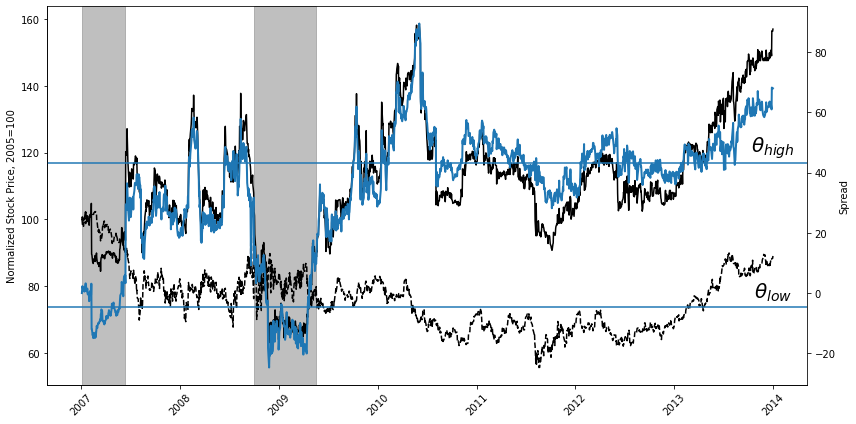

In [43]:
stock1 = 11368
stock2 = 12073


plot_data = (trading.normalize(data[[stock1,stock2]].loc['2007-01-01':'2014-01-01']))
spread = plot_data[stock1]-plot_data[stock2]

curr_regime, low_dates, high_dates = trading.define_highlow_date(spread)

kappa_low, theta_low, sigma_low = trading.estimate_vasicek(plot_data[stock1].loc[low_dates],plot_data[stock2].loc[low_dates])
kappa_high, theta_high, sigma_high = trading.estimate_vasicek(plot_data[stock1].loc[high_dates],plot_data[stock2].loc[high_dates])




fig, axes = plt.subplots(1,figsize=(12,6),facecolor = "white")

ax2 = axes.twinx()
axes.plot(plot_data[stock1],color="black")
axes.plot(plot_data[stock2],color="black",linestyle='dashed')
ax2.plot(spread,linewidth=2)



axes.axvspan(date2num(datetime(2007,1,3)), date2num(datetime(2007,6,13)), color="grey", alpha=0.5) #Manually located from the low_dates list
axes.axvspan(date2num(datetime(2008,10,1)), date2num(datetime(2009,5,19)), color="grey", alpha=0.5) #Manually located from the low_dates list

ax2.axhline(theta_high)
ax2.axhline(theta_low)

ax2.text(date2num(datetime(2014,1,1)), theta_high+5, '$\\theta_{high}$', fontsize=20, va='center', ha='center')
ax2.text(date2num(datetime(2014,1,1)), theta_low+5, '$\\theta_{low}$', fontsize=20, va='center', ha='center')



axes.set_ylabel("Normalized Stock Price, 2005=100")
ax2.set_ylabel('Spread')

axes.tick_params(axis='x', labelrotation = 45)
axes = simpleaxis(axes)

fig.subplots_adjust(bottom=0.02)
fig.tight_layout()

fig.savefig("spread_vasicek_markov.jpg")

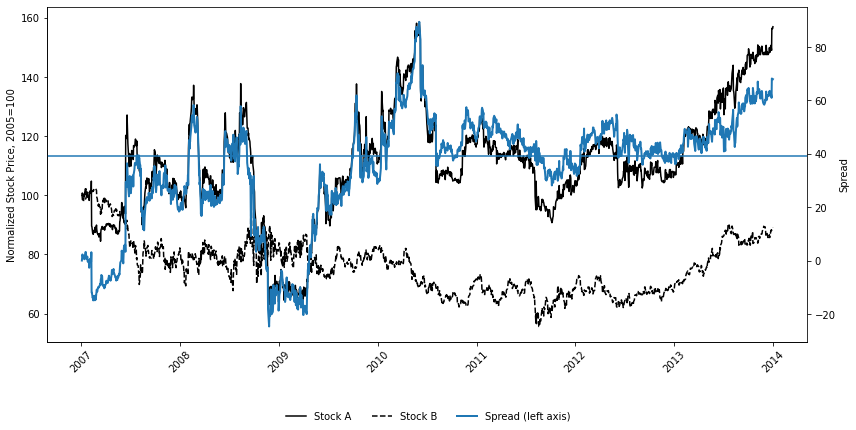

In [572]:
stock1 = 11368
stock2 = 12073


plot_data = (trading.normalize(data[[stock1,stock2]].loc['2007-01-01':'2014-01-01']))
spread = plot_data[stock1]-plot_data[stock2]

curr_regime, low_dates, high_dates = trading.define_highlow_date(spread)

    
kappa, theta, sigma = trading.estimate_vasicek(plot_data[stock1],plot_data[stock2])

fig, axes = plt.subplots(1,figsize=(12,6),facecolor = "white")

ax2 = axes.twinx()
axes.plot(plot_data[stock1],color="black")
axes.plot(plot_data[stock2],color="black",linestyle='dashed')
ax2.plot(spread,linewidth=2)

#axes.axvspan(date2num(datetime(2007,1,3)), date2num(datetime(2007,6,13)), color="grey", alpha=0.5) #Manually located from the low_dates list
#axes.axvspan(date2num(datetime(2008,10,1)), date2num(datetime(2009,5,19)), color="grey", alpha=0.5) #Manually located from the low_dates list

ax2.axhline(theta)
axes.set_ylabel("Normalized Stock Price, 2005=100")
ax2.set_ylabel('Spread')

axes.tick_params(axis='x', labelrotation = 45)
axes = simpleaxis(axes)


fig.subplots_adjust(bottom=0.02)
fig.tight_layout(rect=(0,0.1,1,1))

fig.legend(["Stock A", 'Stock B', 'Spread (left axis)'],loc="lower center",
          frameon=False,
          ncol=3)


fig.savefig("spread_vasicek.jpg")

In [569]:
theta

39.09212751836262

In [388]:
trading.trade(n_pairs=20,end_date='01-01-2012')

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Pairs created for date 2011-01-01 00:00:00
We open a long at -0.9518580129073086 with a profit of 0.0
We closed a long at -0.8904692588714767 with a profit of 0.00061388754035832
We open a long at -1.7621170531801056 with a profit of 0.0
We closed a long at -3.5971079461078688 with a profit of -0.018349908929277632
We open a long at -0.5040383510955166 with a profit of 0.0
We closed a long at -0.725901498508037 with a profit of -0.0022186314741252035
We open a long at -3.024506550807857 with a profit of 0.0
We closed a long at -2.0236667768934637 with a profit of 0.01000839773914393
We open a long at -3.8827154409854643 with a profit of 0.0
Trading window is closed, closing trade. Total profit of: -0.01
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade signals triggered.
Trading window is

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Pairs created for date 2011-01-31 00:00:00
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade signals triggered.
We open a long at 2.0131279570554597 with a profit of 0.0
We closed a long at 1.6799046190781297 with a profit of -0.0033322333797732996
We open a long at 1.0313762341029928 with a profit of 0.0
We closed a long at 0.5328471091663829 with a profit of -0.004985291249366099
We open a long at -0.7665558946428064 with a profit of 0.0
We closed a long at -7.795011142034326 with a profit of -0.0702845524739152
We open a long at -2.574572290370753 with a profit of 0.0
We closed a long at -1.8220252861126198 with a profit of 0.007525470042581333
We open a long at -0.001749662864327206 with a profit of 0.0
Trading window is closed, closing trade. Total profit of: -0.071
We open a long at 0.0 with a profit of 0.0
Trading window is closed, closing trade. Total profit of: -0.087
Trading window is

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Pairs created for date 2011-03-02 00:00:00
Trading window is closed, no trade signals triggered.
We open a long at 0.0 with a profit of 0.0
Trading window is closed, closing trade. Total profit of: -0.037
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade signals triggered.
We open a long at 0.0 with a profit of 0.0
Trading window is closed, closing trade. Total profit of: -0.245
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade sign

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Pairs created for date 2011-04-01 00:00:00
We open a long at -2.727426985458564 with a profit of 0.0
We closed a long at -1.4674348992050028 with a profit of 0.012599920862535611
We open a long at -3.4371990773249763 with a profit of 0.0
We closed a long at -2.847127866673077 with a profit of 0.005900712106518995
Trading window is closed, closing trade. Total profit of: -0.004
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade signals triggered.
We open a long at 0.0 with a profit of 0.0
Trading window is closed, closing trade. Total profit of: -0.008
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade signals triggered.
We closed a short at 1.8857323741252117 with a profit of 0.006105602777547716
We closed a short at 0.9190470834854239 with a profit of 0.013068116867035257
We closed a short at 6.593717280072241 with a profit of -0.043898478952257985
Trading window is closed, closing trade. Total profit of: -0.0

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Pairs created for date 2011-05-01 00:00:00
Trading window is closed, no trade signals triggered.
Trading window is closed, no trade signals triggered.
Error in estimation
Trading window is closed, no trade signals triggered.
Error in estimation
Trading window is closed, no trade signals triggered.
Error in estimation
Trading window is closed, no trade signals triggered.
Error in estimation
Trading window is closed, no trade signals triggered.
Error in estimation
Trading window is closed, no trade signals triggered.
Error in estimation
Trading window is closed, no trade signals triggered.
Error in estimation
Trading window is closed, no trade signals triggered.
Error in estimation
Trading window is closed, no trade signals triggered.
Error in estimation
Trading window is closed, no trade signals triggered.
Error in estimation
Trading window is closed, no trade signals triggered.
Error in estimation
Trading window is closed, no trade signals triggered.
Error in estimation
Trading window 

KeyboardInterrupt: 

<AxesSubplot:>

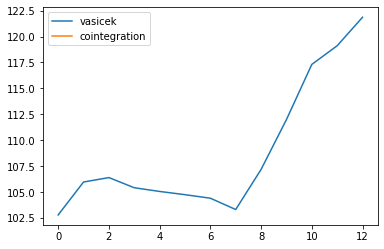

In [27]:
((1+trading.performance[['vasicek','cointegration']]).cumprod()*100).plot()

In [387]:
trading.performance

,date,vasicek,cointegration
0,2011-01-01,-0.001294,0.049819
1,2011-01-31,-0.013682,0.058547
2,2011-03-02,-0.028226,0.030102
3,2011-04-01,-0.003718,0.018529
4,2011-05-01,0.006795,0.049753
5,2011-05-31,0.000000,0.020628
6,2011-06-30,0.000000,0.029524
7,2011-07-30,-0.004005,0.070210
8,2011-08-29,-0.019760,0.041117
9,2011-09-28,-0.022853,0.045155


In [ ]:
trading.performance['vasicek']

In [26]:
trading.performance['vasicek'].std()*np.sqrt(12)

0.07270919989379541

In [22]:
class trading_log:
    
    def __init__(self,show_message=True):
        #Creating position variables
        pos_type = 'none' #Can take following form: 'long', 'short', 'none'
        pos_status = 'closed' #Can take following form: 'open', 'closed'
        portfolio_log = pd.DataFrame(columns=['price','pos_type','pos_status','time','profit'])
        portfolio_log.loc[portfolio_log.shape[0]] = [0,'none','closed',0,0]

        
        self.show_message = show_message
        self.portfolio = portfolio_log
        
    def open_short(self,time,price):
        
        if (self.portfolio['pos_status'].iloc[-1] == 'open') & (self.portfolio['pos_type'].iloc[-1] == 'short'): #If trade already executed
                    pass #Next time period

        elif (self.portfolio['pos_status'].iloc[-1] == 'open') & (self.portfolio['pos_type'].iloc[-1] == 'long'): #If long trade ongoing, opening new short trade
            pos_status = 'open'
            pos_type = 'short'
            price = price
            time = time
            profit = price - self.portfolio['price'].iloc[-1]
            
            if self.show_message == True:
                print('We '+ str(pos_status)+ " a " + str(pos_type) + " at "+ str(price) + " with a profit of " + str(profit/100))
            self.portfolio.loc[self.portfolio.shape[0]] = [price,pos_type,pos_status,time,profit]

        elif self.portfolio['pos_status'].iloc[-1] == 'closed': #Opening a new trade
            pos_status = 'open'
            pos_type = 'short'
            price = price
            time = time
            profit = 0
            
            self.portfolio.loc[self.portfolio.shape[0]] = [price,pos_type,pos_status,time,profit]
        
    def open_long(self,time,price):
        if (self.portfolio['pos_status'].iloc[-1] == 'open') & (self.portfolio['pos_type'].iloc[-1] == 'long'): #If trade already executed
            pass #Next time period

        elif (self.portfolio['pos_status'].iloc[-1] == 'open') & (self.portfolio['pos_type'].iloc[-1] == 'short'): #If short trade ongoing, opening new long trade
            pos_status = 'open'
            pos_type = 'long'
            price = price
            time = time
            profit =self.portfolio['price'].iloc[-1]-price
            
            self.portfolio.loc[self.portfolio.shape[0]] = [price,pos_type,pos_status,time,profit]

            if self.show_message == True:
                print('We '+ str(pos_status)+ " a " + str(pos_type) + " at "+ str(price) + " with a profit of " + str(profit/100))
            
        elif self.portfolio['pos_status'].iloc[-1] == 'closed': #Opening a new trade
            pos_status = 'open'
            pos_type = 'long'
            price = price
            time = time
            profit = 0
            
            self.portfolio.loc[self.portfolio.shape[0]] = [price,pos_type,pos_status,time,profit]
            
            if self.show_message == True:
                print('We '+ str(pos_status)+ " a " + str(pos_type) + " at "+ str(price) + " with a profit of " + str(profit/100))
    
    def close(self,time,price):
        if self.portfolio['pos_status'].iloc[-1] == 'closed':
            pass

        elif (self.portfolio['pos_status'].iloc[-1] == 'open') & (self.portfolio['pos_type'].iloc[-1] == 'long'):
            pos_status = 'closed'
            pos_type = 'long'
            price = price
            time = time
            profit = price - self.portfolio['price'].iloc[-1]
            self.portfolio.loc[self.portfolio.shape[0]] = [price,pos_type,pos_status,time,profit]

            if self.show_message == True:
                print('We '+ str(pos_status)+ " a " + str(pos_type) + " at "+ str(price) + " with a profit of " + str(profit/100))


        elif (self.portfolio['pos_status'].iloc[-1] == 'open') & (self.portfolio['pos_type'].iloc[-1] == 'short'):
            pos_status = 'closed'
            pos_type = 'short'
            price = price
            time = time
            profit =self.portfolio['price'].iloc[-1]-price
            
            self.portfolio.loc[self.portfolio.shape[0]] = [price,pos_type,pos_status,time,profit]

            if self.show_message == True:
                print('We '+ str(pos_status)+ " a " + str(pos_type) + " at "+ str(price) + " with a profit of " + str(profit/100))
    
    def finish_trade(self,time,price):

        if self.portfolio.shape[0] == 1:
            pos_status = 'closed'
            pos_type = 'none'
            price = price
            time = time
            profit = 0

            self.portfolio.loc[self.portfolio.shape[0]] = [price,pos_type,pos_status,time,profit]
            self.profit = 0
        
            if self.show_message == True:
                print("Trading window is closed, no trade signals triggered.")
        else:  
            pos_status = 'closed'
            pos_type = 'none'
            price = price
            time = time
            profit = self.portfolio['price'].iloc[-1]-price

            self.portfolio.loc[self.portfolio.shape[0]] = [price,pos_type,pos_status,time,profit]
            self.profit = (((1+self.portfolio['profit']/100).cumprod())-1).iloc[-1]

            if self.show_message == True:
                    print("Trading window is closed, closing trade. Total profit of: " + str(round(self.profit,3)))


In [251]:
portfolio_log

,price,pos_type,pos_status,time,profit
0,0,none,closed,0,0


In [254]:
portfolio_log.shape[0]

1